## Streamflow Routing Package Problem 1

This is the stream-aquifer interaction example problem (test 1) from the
Streamflow Routing Package documentation (Prudic, 1989). All reaches have
been converted to rectangular reaches.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pooch
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-sfr-p01"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "feet"
time_units = "seconds"

# Model parameters
nper = 3  # Number of periods
nlay = 1  # Number of layers
nrow = 15  # Number of rows
ncol = 10  # Number of columns
delr = 5000.0  # Column width ($ft$)
delc = 5000.0  # Row width ($ft$)
strt = 1050.0  # Starting head ($ft$)
k11_stream = 0.002  # Hydraulic conductivity near the stream ($ft/s$)
k11_basin = 0.0004  # Hydraulic conductivity in the basin ($ft/s$)
ss = 1e-6  # Specific storage ($1/s)$
sy_stream = 0.2  # Specific yield near the stream (unitless)
sy_basin = 0.1  # Specific yield in the basin (unitless)
evap_rate = 9.5e-8  # Evapotranspiration rate ($ft/s$)
ext_depth = 15.0  # Evapotranspiration extinction depth ($ft$)

# Time discretization
tdis_ds = (
    (0.0, 1, 1.0),
    (1.577880e9, 50, 1.1),
    (1.577880e9, 50, 1.1),
)

# Define dimensions
extents = (0.0, delr * ncol, 0.0, delc * nrow)
shape2d = (nrow, ncol)
shape3d = (nlay, nrow, ncol)

# Load the idomain, top, bottom, and evapotranspiration surface arrays
fname = "idomain.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:a0b12472b8624aecdc79e5c19c97040c",
)
idomain = np.loadtxt(fpath, dtype=int)
fname = "top.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:ab5097c1dc22e60fb313bf7f10dd8efe",
)
top = np.loadtxt(fpath, dtype=float)
fname = "bottom.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:fa5fe276f4f58a01eabfe88516cc90af",
)
botm = np.loadtxt(fpath, dtype=float)
fname = "recharge.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:82ed1ed29a457f1f38e51cd2657676e1",
)
recharge = np.loadtxt(fpath, dtype=float)
fname = "surf.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:743ce03e5e46867cf5af94f1ac283514",
)
surf = np.loadtxt(fpath, dtype=float)

# Create hydraulic conductivity and specific yield
k11 = np.zeros(shape2d, dtype=float)
k11[idomain == 1] = k11_stream
k11[idomain == 2] = k11_basin
sy = np.zeros(shape2d, dtype=float)
sy[idomain == 1] = sy_stream
sy[idomain == 2] = sy_basin

# General head boundary conditions
ghb_spd = [
    [0, 12, 0, 988.0, 0.038],
    [0, 13, 8, 1045.0, 0.038],
]

# Well boundary conditions
wel_spd = {
    1: [
        [0, 5, 3, -10.0],
        [0, 5, 4, -10.0],
        [0, 6, 3, -10.0],
        [0, 6, 4, -10.0],
        [0, 7, 3, -10.0],
        [0, 7, 4, -10.0],
        [0, 8, 3, -10.0],
        [0, 8, 4, -10.0],
        [0, 9, 3, -10.0],
        [0, 9, 4, -10.0],
    ],
    2: [
        [],
    ],
}

# SFR Package
sfr_pakdata = [
    [
        0,
        0,
        0,
        0,
        4500.0,
        12,
        8.6767896e-04,
        1093.048,
        3.0,
        0.00003,
        0.030,
        1,
        1.0,
        0,
    ],
    [
        1,
        0,
        1,
        1,
        7000.0,
        12,
        8.6767896e-04,
        1088.059,
        3.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        2,
        0,
        2,
        2,
        6000.0,
        12,
        8.6767896e-04,
        1082.419,
        3.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        3,
        0,
        2,
        3,
        5550.0,
        12,
        8.6767896e-04,
        1077.408,
        3.0,
        0.00003,
        0.030,
        3,
        1.0,
        1,
    ],
    [
        4,
        0,
        3,
        4,
        6500.0,
        12,
        9.4339624e-04,
        1071.934,
        3.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        5,
        0,
        4,
        5,
        5000.0,
        12,
        9.4339624e-04,
        1066.509,
        3.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        6,
        0,
        5,
        5,
        5000.0,
        12,
        9.4339624e-04,
        1061.792,
        3.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        7,
        0,
        6,
        5,
        5000.0,
        12,
        9.4339624e-04,
        1057.075,
        3.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        8,
        0,
        7,
        5,
        5000.0,
        12,
        9.4339624e-04,
        1052.359,
        3.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        9,
        0,
        2,
        4,
        5000.0,
        10,
        5.4545456e-04,
        1073.636,
        2.0,
        0.00003,
        0.030,
        2,
        0.0,
        0,
    ],
    [
        10,
        0,
        2,
        5,
        5000.0,
        10,
        5.4545456e-04,
        1070.909,
        2.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        11,
        0,
        2,
        6,
        4500.0,
        10,
        5.4545456e-04,
        1068.318,
        2.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        12,
        0,
        3,
        7,
        6000.0,
        10,
        5.4545456e-04,
        1065.455,
        2.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        13,
        0,
        4,
        7,
        5000.0,
        10,
        5.4545456e-04,
        1062.455,
        2.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        14,
        0,
        5,
        7,
        2000.0,
        10,
        5.4545456e-04,
        1060.545,
        2.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        15,
        0,
        4,
        9,
        2500.0,
        10,
        1.8181818e-03,
        1077.727,
        3.0,
        0.00003,
        0.030,
        1,
        1.0,
        0,
    ],
    [
        16,
        0,
        4,
        8,
        5000.0,
        10,
        1.8181818e-03,
        1070.909,
        3.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        17,
        0,
        5,
        7,
        3500.0,
        10,
        1.8181818e-03,
        1063.182,
        3.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        18,
        0,
        5,
        7,
        4000.0,
        15,
        1.0000000e-03,
        1058.000,
        3.0,
        0.00003,
        0.030,
        3,
        1.0,
        0,
    ],
    [
        19,
        0,
        6,
        6,
        5000.0,
        15,
        1.0000000e-03,
        1053.500,
        3.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        20,
        0,
        7,
        6,
        3500.0,
        15,
        1.0000000e-03,
        1049.250,
        3.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        21,
        0,
        7,
        5,
        2500.0,
        15,
        1.0000000e-03,
        1046.250,
        3.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        22,
        0,
        8,
        5,
        5000.0,
        12,
        9.0909092e-04,
        1042.727,
        3.0,
        0.00003,
        0.030,
        3,
        1.0,
        0,
    ],
    [
        23,
        0,
        9,
        6,
        5000.0,
        12,
        9.0909092e-04,
        1038.182,
        3.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        24,
        0,
        10,
        6,
        5000.0,
        12,
        9.0909092e-04,
        1033.636,
        3.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        25,
        0,
        11,
        6,
        5000.0,
        12,
        9.0909092e-04,
        1029.091,
        3.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        26,
        0,
        12,
        6,
        2000.0,
        12,
        9.0909092e-04,
        1025.909,
        3.0,
        0.00003,
        0.030,
        2,
        1.0,
        0,
    ],
    [
        27,
        0,
        13,
        8,
        5000.0,
        55,
        9.6774194e-04,
        1037.581,
        3.0,
        0.00006,
        0.025,
        1,
        1.0,
        0,
    ],
    [
        28,
        0,
        12,
        7,
        5500.0,
        55,
        9.6774194e-04,
        1032.500,
        3.0,
        0.00006,
        0.025,
        2,
        1.0,
        0,
    ],
    [
        29,
        0,
        12,
        6,
        5000.0,
        55,
        9.6774194e-04,
        1027.419,
        3.0,
        0.00006,
        0.025,
        2,
        1.0,
        0,
    ],
    [
        30,
        0,
        12,
        5,
        5000.0,
        40,
        1.2500000e-03,
        1021.875,
        3.0,
        0.00006,
        0.025,
        3,
        1.0,
        0,
    ],
    [
        31,
        0,
        12,
        4,
        5000.0,
        40,
        1.2500000e-03,
        1015.625,
        3.0,
        0.00006,
        0.025,
        2,
        1.0,
        0,
    ],
    [
        32,
        0,
        12,
        3,
        5000.0,
        40,
        1.2500000e-03,
        1009.375,
        3.0,
        0.00006,
        0.025,
        2,
        1.0,
        0,
    ],
    [
        33,
        0,
        12,
        2,
        5000.0,
        40,
        1.2500000e-03,
        1003.125,
        3.0,
        0.00006,
        0.025,
        2,
        1.0,
        0,
    ],
    [
        34,
        0,
        12,
        1,
        5000.0,
        40,
        1.2500000e-03,
        996.8750,
        3.0,
        0.00006,
        0.025,
        2,
        1.0,
        0,
    ],
    [
        35,
        0,
        12,
        0,
        3000.0,
        40,
        1.2500000e-03,
        991.8750,
        3.0,
        0.00006,
        0.025,
        1,
        1.0,
        0,
    ],
]

sfr_conn = [
    [0, -1],
    [1, 0, -2],
    [2, 1, -3],
    [3, 2, -4, -9],
    [4, 3, -5],
    [5, 4, -6],
    [6, 5, -7],
    [7, 6, -8],
    [8, 7, -22],
    [9, 3, -10],
    [10, 9, -11],
    [11, 10, -12],
    [12, 11, -13],
    [13, 12, -14],
    [14, 13, -18],
    [15, -16],
    [16, 15, -17],
    [17, 16, -18],
    [18, 14, 17, -19],
    [19, 18, -20],
    [20, 19, -21],
    [21, 20, -22],
    [22, 8, 21, -23],
    [23, 22, -24],
    [24, 23, -25],
    [25, 24, -26],
    [26, 25, -30],
    [27, -28],
    [28, 27, -29],
    [29, 28, -30],
    [30, 26, 29, -31],
    [31, 30, -32],
    [32, 31, -33],
    [33, 32, -34],
    [34, 33, -35],
    [35, 34],
]

sfr_div = [[3, 0, 9, "UPTO"]]

sfr_spd = [
    [0, "inflow", 25.0],
    [15, "inflow", 10.0],
    [27, "inflow", 150.0],
    [3, "diversion", 0, 10.0],
    [9, "status", "simple"],
    [10, "status", "simple"],
    [11, "status", "simple"],
    [12, "status", "simple"],
    [13, "status", "simple"],
    [14, "status", "simple"],
    [9, "stage", 1075.545],
    [10, "stage", 1072.636],
    [11, "stage", 1069.873],
    [12, "stage", 1066.819],
    [13, "stage", 1063.619],
    [14, "stage", 1061.581],
]

# Solver parameters
nouter = 100
ninner = 50
hclose = 1e-6
rclose = 1e-6

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models():
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        linear_acceleration="bicgstab",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=sim_name, newtonoptions="newton", save_flows=True
    )
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        idomain=idomain,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=1,
        k=k11,
        save_specific_discharge=True,
    )
    flopy.mf6.ModflowGwfsto(
        gwf,
        iconvert=1,
        sy=sy,
        ss=ss,
        steady_state={0: True},
        transient={1: True},
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfghb(gwf, stress_period_data=ghb_spd)
    flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd)
    flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
    flopy.mf6.ModflowGwfevta(gwf, surface=surf, rate=evap_rate, depth=ext_depth)
    sfr = flopy.mf6.ModflowGwfsfr(
        gwf,
        length_conversion=3.28081,
        nreaches=len(sfr_pakdata),
        packagedata=sfr_pakdata,
        connectiondata=sfr_conn,
        diversions=sfr_div,
        perioddata=sfr_spd,
    )
    obs_file = f"{sim_name}.sfr.obs"
    csv_file = obs_file + ".csv"
    obs_dict = {
        csv_file: [
            ("r01_stage", "stage", (3,)),
            ("r02_stage", "stage", (14,)),
            ("r03_stage", "stage", (26,)),
            ("r04_stage", "stage", (35,)),
            ("r01_flow", "downstream-flow", (3,)),
            ("r02_flow", "downstream-flow", (14,)),
            ("r03_flow", "downstream-flow", (26,)),
            ("r04_flow", "downstream-flow", (35,)),
        ]
    }
    sfr.obs.initialize(
        filename=obs_file, digits=10, print_input=True, continuous=obs_dict
    )

    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6.3, 5.6)
masked_values = (0, 1e30, -1e30)


def plot_grid(gwf, silent=True):
    with styles.USGSMap() as fs:
        fig = plt.figure(figsize=figure_size, constrained_layout=False)
        gs = mpl.gridspec.GridSpec(ncols=10, nrows=7, figure=fig, wspace=5)
        plt.axis("off")

        axes = []
        axes.append(fig.add_subplot(gs[:6, :5]))
        axes.append(fig.add_subplot(gs[:6, 5:], sharey=axes[0]))

        for ax in axes:
            ax.set_xlim(extents[:2])
            ax.set_ylim(extents[2:])
            ax.set_aspect("equal")
            # ax.set_xticks(ticklabels)
            # ax.set_yticks(ticklabels)

        # legend axis
        axes.append(fig.add_subplot(gs[6:, :]))

        # set limits for legend area
        ax = axes[-1]
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        # get rid of ticks and spines for legend area
        ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_color("none")
        ax.spines["bottom"].set_color("none")
        ax.spines["left"].set_color("none")
        ax.spines["right"].set_color("none")
        ax.patch.set_alpha(0.0)

        ax = axes[0]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        top_coll = mm.plot_array(
            top, vmin=1000, vmax=1120, masked_values=masked_values, alpha=0.5
        )
        mm.plot_bc("SFR", color="green")
        cv = mm.contour_array(
            top,
            levels=np.arange(1000, 1100, 20),
            linewidths=0.5,
            linestyles="-",
            colors="black",
            masked_values=masked_values,
        )
        plt.clabel(cv, fmt="%1.0f")
        mm.plot_inactive(color_noflow="0.5")
        mm.plot_grid(lw=0.5, color="black")
        cbar = plt.colorbar(
            top_coll,
            shrink=0.8,
            orientation="horizontal",
            ax=ax,
            format="%.0f",
        )
        cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Land surface elevation, $ft$")
        ax.set_xlabel("x-coordinate, in feet")
        ax.set_ylabel("y-coordinate, in feet")
        styles.heading(ax, heading="Land surface elevation", idx=0)
        styles.remove_edge_ticks(ax)

        ax = axes[1]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        bot_coll = mm.plot_array(
            botm, vmin=500, vmax=1000, masked_values=masked_values, alpha=0.5
        )
        mm.plot_bc("GHB", color="purple")
        mm.plot_bc("WEL", color="red", kper=1)
        cv = mm.contour_array(
            botm,
            levels=np.arange(600, 1000, 100),
            linewidths=0.5,
            linestyles=":",
            colors="black",
            masked_values=masked_values,
        )
        plt.clabel(cv, fmt="%1.0f")
        mm.plot_inactive(color_noflow="0.5")
        mm.plot_grid(lw=0.5, color="black")
        cbar = plt.colorbar(
            bot_coll,
            shrink=0.8,
            orientation="horizontal",
            ax=ax,
            format="%.0f",
        )
        cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Bottom elevation, $ft$")
        ax.set_xlabel("x-coordinate, in feet")
        styles.heading(ax, heading="Bottom elevation", idx=1)
        styles.remove_edge_ticks(ax)

        # legend
        ax = axes[-1]
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="0.5",
            mec="black",
            markeredgewidth=0.5,
            label="Inactive cells",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="green",
            mec="black",
            markeredgewidth=0.5,
            label="Stream boundary",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="purple",
            mec="black",
            markeredgewidth=0.5,
            label="General head boundary",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="red",
            mec="black",
            markeredgewidth=0.5,
            label="Well boundary",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0.5,
            ls="-",
            color="black",
            label=r"Land surface elevation contour, $ft$",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0.5,
            ls=":",
            color="black",
            label=r"Bottom elevation contour, $ft$",
        )
        styles.graph_legend(ax, loc="center", ncol=3)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)


def plot_head_results(gwf, silent=True):
    # create MODFLOW 6 head object
    hobj = gwf.output.head()

    # create MODFLOW 6 cell-by-cell budget object
    cobj = gwf.output.budget()

    kstpkper = hobj.get_kstpkper()

    with styles.USGSMap():
        fig = plt.figure(figsize=figure_size, constrained_layout=False)
        gs = mpl.gridspec.GridSpec(ncols=10, nrows=7, figure=fig, wspace=5)
        plt.axis("off")

        axes = [fig.add_subplot(gs[:6, :5])]
        axes.append(fig.add_subplot(gs[:6, 5:], sharey=axes[0]))

        for ax in axes:
            ax.set_xlim(extents[:2])
            ax.set_ylim(extents[2:])
            ax.set_aspect("equal")

        # legend axis
        axes.append(fig.add_subplot(gs[6:, :]))

        # set limits for legend area
        ax = axes[-1]
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        # get rid of ticks and spines for legend area
        ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_color("none")
        ax.spines["bottom"].set_color("none")
        ax.spines["left"].set_color("none")
        ax.spines["right"].set_color("none")
        ax.patch.set_alpha(0.0)

        # extract heads and specific discharge for first stress period
        head = hobj.get_data(kstpkper=kstpkper[0])
        qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
            cobj.get_data(text="DATA-SPDIS", kstpkper=kstpkper[0])[0],
            gwf,
        )

        ax = axes[0]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        head_coll = mm.plot_array(
            head, vmin=900, vmax=1120, masked_values=masked_values
        )
        cv = mm.contour_array(
            head,
            levels=np.arange(900, 1100, 10),
            linewidths=0.5,
            linestyles="-",
            colors="black",
            masked_values=masked_values,
        )
        plt.clabel(cv, fmt="%1.0f")
        mm.plot_vector(qx, qy, normalize=True, color="0.75")
        mm.plot_inactive(color_noflow="0.5")
        mm.plot_grid(lw=0.5, color="black")
        ax.set_xlabel("x-coordinate, in feet")
        ax.set_ylabel("y-coordinate, in feet")
        styles.heading(ax, heading="Steady-state", idx=0)
        styles.remove_edge_ticks(ax)

        # extract heads and specific discharge for second stress period
        head = hobj.get_data(kstpkper=kstpkper[1])
        qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
            cobj.get_data(text="DATA-SPDIS", kstpkper=kstpkper[1])[0],
            gwf,
        )

        ax = axes[1]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        head_coll = mm.plot_array(
            head, vmin=900, vmax=1120, masked_values=masked_values
        )
        cv = mm.contour_array(
            head,
            levels=np.arange(900, 1100, 10),
            linewidths=0.5,
            linestyles="-",
            colors="black",
            masked_values=masked_values,
        )
        plt.clabel(cv, fmt="%1.0f")
        mm.plot_vector(qx, qy, normalize=True, color="0.75")
        mm.plot_inactive(color_noflow="0.5")
        mm.plot_grid(lw=0.5, color="black")
        ax.set_xlabel("x-coordinate, in feet")
        styles.heading(ax, heading="Pumping", idx=1)
        styles.remove_edge_ticks(ax)

        # legend
        ax = axes[-1]
        cbar = plt.colorbar(
            head_coll,
            shrink=0.8,
            orientation="horizontal",
            ax=ax,
            format="%.0f",
        )
        cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Head, $ft$")
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="$\u2192$",
            ms=10,
            mfc="0.75",
            mec="0.75",
            label="Normalized specific discharge",
        )
        ax.plot(-10000, -10000, lw=0.5, color="black", label=r"Head contour, $ft$")
        styles.graph_legend(ax, loc="upper center", ncol=2)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-01.png"
            fig.savefig(fpth)


def plot_sfr_results(gwf, silent=True):
    with styles.USGSPlot():
        # load the observations
        results = gwf.sfr.output.obs().data

        # modify the time
        results["totim"] /= 365.25 * 86400.0

        rnos = (
            3,
            14,
            26,
            35,
        )
        sfr = gwf.sfr.packagedata.array["rtp"]
        offsets = []
        for rno in rnos:
            offsets.append(sfr[rno])

        # create the figure
        fig, axes = plt.subplots(
            ncols=2,
            nrows=4,
            sharex=True,
            figsize=(6.3, 6.3),
            constrained_layout=True,
        )
        ipos = 0
        for i in range(4):
            heading = f"Reach {rnos[i] + 1}"
            for j in range(2):
                ax = axes[i, j]
                ax.set_xlim(0, 100)
                if j == 0:
                    tag = f"R{i + 1:02d}_STAGE"
                    offset = offsets[i]
                    scale = 1.0
                    ylabel = "Reach depth, in feet"
                    color = "blue"
                else:
                    tag = f"R{i + 1:02d}_FLOW"
                    offset = 0.0
                    scale = -1.0
                    ylabel = "Downstream reach flow,\nin cubic feet per second"
                    color = "red"

                ax.plot(
                    results["totim"],
                    scale * results[tag] - offset,
                    lw=0.5,
                    color=color,
                    zorder=10,
                )
                ax.axvline(50, lw=0.5, ls="--", color="black", zorder=10)
                if ax.get_ylim()[0] < 0.0:
                    ax.axhline(0, lw=0.5, color="0.5", zorder=9)
                styles.add_text(
                    ax,
                    text="Pumping",
                    x=0.49,
                    y=0.8,
                    ha="right",
                    bold=False,
                    fontsize=7,
                )
                styles.add_text(
                    ax,
                    text="Recovery",
                    x=0.51,
                    y=0.8,
                    ha="left",
                    bold=False,
                    fontsize=7,
                )
                ax.set_ylabel(ylabel)
                ax.yaxis.set_label_coords(-0.1, 0.5)
                styles.heading(ax, heading=heading, idx=ipos)
                if i == 3:
                    ax.set_xlabel("Time since pumping began, in years")
                ipos += 1

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-02.png"
            fig.savefig(fpth)


def plot_results(sim, silent=True):
    gwf = sim.get_model(sim_name)
    plot_grid(gwf, silent=silent)
    plot_sfr_results(gwf, silent=silent)
    plot_head_results(gwf, silent=silent)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

run_models took 374.56 ms


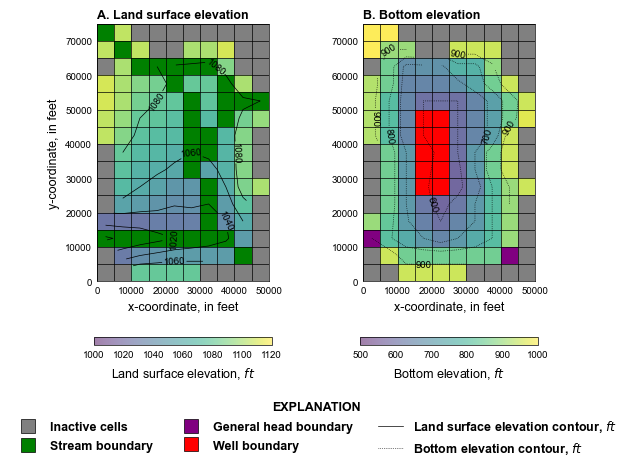

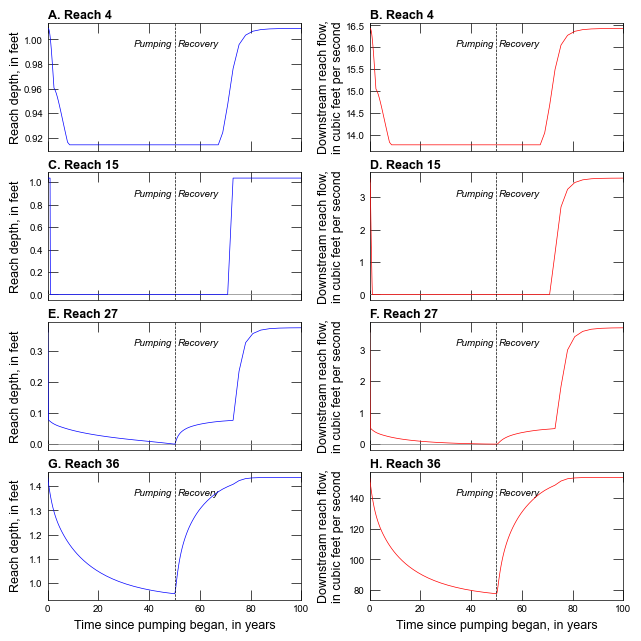

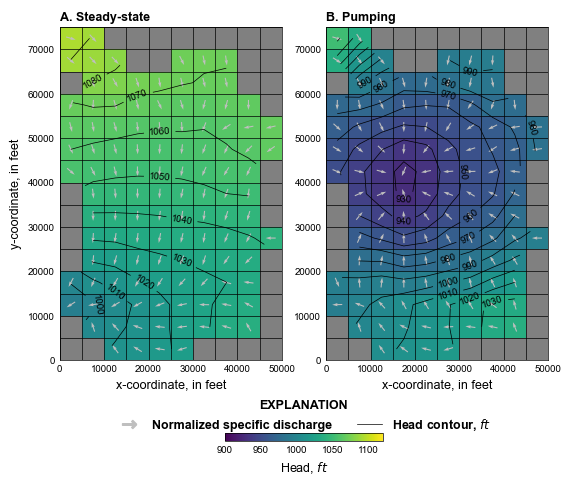

In [5]:
def scenario(silent=True):
    sim = build_models()
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, silent=silent)


# Simulated heads in model the unconfined, middle, and lower aquifers (model layers
# 1, 3, and 5) are shown in the figure below. MODFLOW-2005 results for a quasi-3D
# model are also shown. The location of drain (green) and well (gray) boundary
# conditions, normalized specific discharge, and head contours (25 ft contour
# intervals) are also shown.
scenario()